In [10]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
# before plotting, ensure default (white) style
plt.style.use('default')
plt.rcParams['font.family']  = 'serif'
plt.rcParams['font.serif']   = ['Times New Roman']

# Load SPX classification
spx_cls = pd.read_csv('SPX_Classification.csv')
year_to_regime = dict(zip(spx_cls['Year'], spx_cls['Market']))
year_to_regime

{2000: 'Sideways',
 2001: 'Sideways',
 2002: 'Bear',
 2003: 'Bull',
 2004: 'Sideways',
 2005: 'Sideways',
 2006: 'Sideways',
 2007: 'Sideways',
 2008: 'Bear',
 2009: 'Sideways',
 2010: 'Sideways',
 2011: 'Sideways',
 2012: 'Sideways',
 2013: 'Bull',
 2014: 'Sideways',
 2015: 'Sideways',
 2016: 'Sideways',
 2017: 'Sideways',
 2018: 'Sideways',
 2019: 'Bull',
 2020: 'Sideways',
 2021: 'Bull',
 2022: 'Sideways',
 2023: 'Bull'}

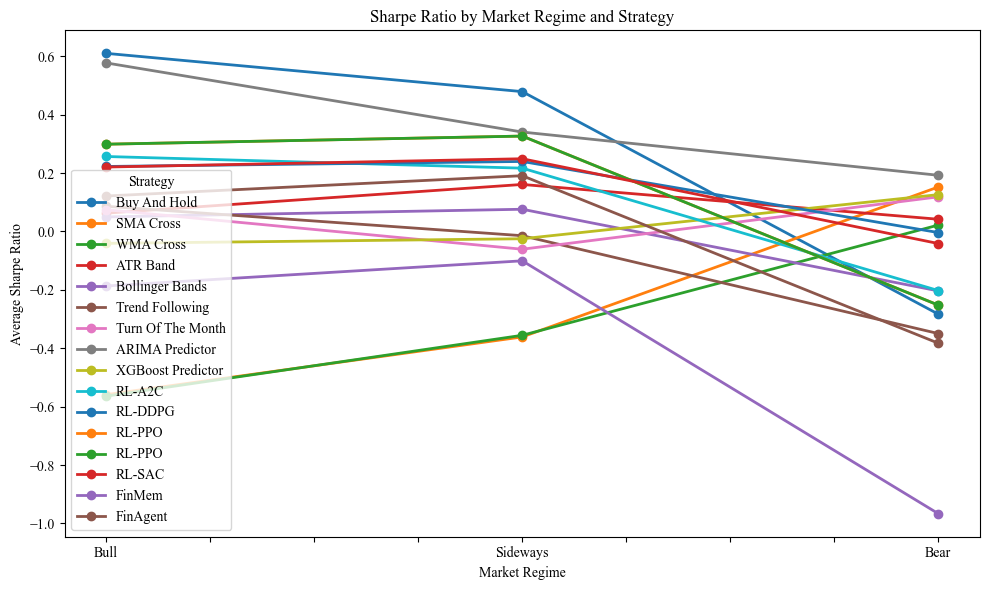

In [11]:
selection_strategies = ["lowvol_sp500_5", "random_sp500_5", "momentum_sp500_5"] 
strategies = [
    ("BuyAndHoldStrategy", "Buy And Hold"),
    ("SMACrossStrategy", "SMA Cross"),
    ("WMAStrategy", "WMA Cross"),
    ("ATRBandStrategy", "ATR Band"),
    ("BollingerBandsStrategy", "Bollinger Bands"),
    ("TrendFollowingStrategy", "Trend Following"),
    ("TurnOfTheMonthStrategy", "Turn Of The Month"),
    ("ARIMAPredictorStrategy", "ARIMA Predictor"),
    ("XGBoostPredictorStrategy", "XGBoost Predictor"),
    ("FinRLStrategy/A2C", "RL-A2C"),
    ("FinRLStrategy/DDPG", "RL-DDPG"),
    ("FinRLStrategy/PPO", "RL-PPO"),
    ("FinRLStrategy/PPO", "RL-PPO"),
    ("FinRLStrategy/SAC", "RL-SAC"),
    ("FinMemStrategy", "FinMem"),
    ("FinAgentStrategy", "FinAgent"),
]

# Gather result CSVs
files = [f"{strategy}/results.csv" for strategy in strategies]

records = []
for strategy, strategy_name in strategies:
    # collect per-fold regime sharpe
    fold_sharpes = []
    
    for sel in selection_strategies:
        fpath = f"{sel}/{strategy}/results.csv"
        if not os.path.exists(fpath):
            continue
        df = pd.read_csv(fpath)
        df = df[df['Period'] != 'Average']
        df[['Start', 'End']] = df['Period'].str.split('_', expand=True)
        df['Year'] = pd.to_datetime(df['Start'], format='%Y-%m-%d').dt.year
        df['Regime'] = df['Year'].map(year_to_regime)
        df = df.dropna(subset=['Regime'])
        sharpe = df.groupby('Regime')['sharpe_ratio'].mean().to_dict()
        fold_sharpes.append(sharpe)
    
    # average across folds
    regimes = ["Bull", "Sideways", "Bear"]
    avg_sharpe = {}
    for regime in regimes:
        vals = [fold.get(regime, np.nan) for fold in fold_sharpes]
        avg_sharpe[regime] = np.nanmean(vals) if vals else np.nan
    
    records.append({
        'Strategy': strategy_name,
        **avg_sharpe
    })

# Build summary DataFrame
summary_sharpe = pd.DataFrame.from_records(records).set_index('Strategy')

# Plot line chart
ax = summary_sharpe.T.plot(
    kind='line',
    figsize=(10, 6),
    marker='o',
    linewidth=2
)
ax.set_xlabel('Market Regime')
ax.set_ylabel('Average Sharpe Ratio')
ax.set_title('Sharpe Ratio by Market Regime and Strategy')
plt.tight_layout()
plt.show()

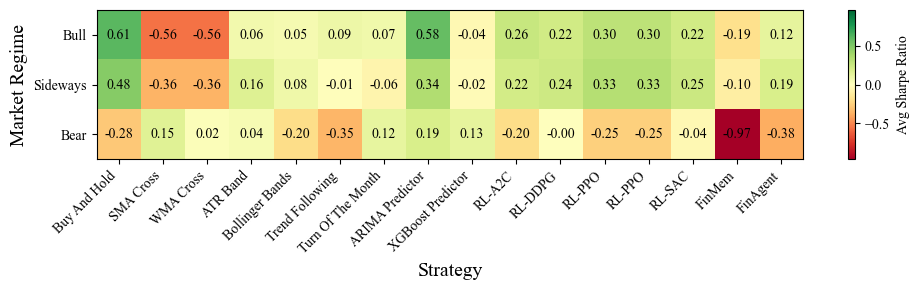

In [24]:
# Annotated Heatmap
df_t = summary_sharpe.T  # rows=Regimes, cols=Strategies
max_abs = np.nanmax(np.abs(df_t.values))

fig, ax = plt.subplots(figsize=(10, 3), facecolor='white')
ax.set_facecolor('white')
im = ax.imshow(df_t.values, aspect='auto', cmap='RdYlGn', vmin=-max_abs, vmax=max_abs)

# Tick labels
ax.set_xticks(np.arange(df_t.shape[1]))
ax.set_xticklabels(df_t.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(df_t.shape[0]))
ax.set_yticklabels(df_t.index)

# Annotate each cell with the Sharpe value
for i in range(df_t.shape[0]):
    for j in range(df_t.shape[1]):
        val = df_t.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

# Colorbar and layout
plt.colorbar(im, ax=ax, label='Avg Sharpe Ratio')
# ax.set_title('Sharpe Ratio by Strategy and Market Regime', fontsize=16)
ax.set_xlabel('Strategy', fontsize=14)
ax.set_ylabel('Market Regime', fontsize=14)
plt.tight_layout()
# plt.savefig('sharpe_heatmap.png', dpi=600)
# save to pdf
plt.savefig('sharpe_heatmap.pdf', dpi=600)

In [29]:
import json
records_json = json.dumps(records, indent=2)
with open('sharpe_records.json', 'w') as f:
    f.write(records_json)